# __MODELO ZIFRA (Cantidad oro extraido)__

Predecir la cantidad de oro extraído del mineral de oro

In [257]:
# Importamos librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.pipeline import Pipeline


## DESCRIPCION DE LOS DATOS
### Proceso tecnológico

- Rougher feed: materia prima
- Rougher additions (o adiciones de reactivos): reactivos de flotación: xantato, sulfato, depresante
    - Xantato: promotor o activador de la flotación
    - Sulfato: sulfuro de sodio para este proceso en particular
    - Depresante: silicato de sodio
- Rougher process: flotación
- Rougher tails: residuos del producto
- Float banks: instalación de flotación
- Cleaner process: purificación
- Rougher Au: concentrado de oro rougher
- Final Au: concentrado de oro final

### Parámetros de las etapas
- air amount: volumen de aire
- fluid levels
- feed size: tamaño de las partículas de la alimentación
- feed rate

## DENOMINACION DE LAS CARACTERISTICAS
Así es como se denominan las características:

[stage].[parameter_type].[parameter_name]

__Ejemplo: rougher.input.feed_ag__

### __Valores posibles para [stage]:__
- rougher: flotación
- primary_cleaner: purificación primaria
- secondary_cleaner: purificación secundaria
- final: características finales

### __Valores posibles para [parameter_type]:__
- input: parámetros de la materia prima
- output: parámetros del producto
- state: parámetros que caracterizan el estado actual de la etapa
- calculation: características de cálculo

# 1. Prepara los datos

## 1. Abre los archivos y examina los datos.

In [258]:
# Cargamos el dataset
df_full = pd.read_csv('datasets/gold_recovery_full.csv')
df_test = pd.read_csv('datasets/gold_recovery_test.csv')
df_train = pd.read_csv('datasets/gold_recovery_train.csv')


In [259]:
# Revisamos datos de la informacion completa
print(df_full.info())
print(df_full.describe())
print(df_full.isnull().mean())
print(df_full.duplicated().sum())
df_full.head(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [260]:
# Revisamos datos de la informacion de entrenamiento
print(df_train.info())
print(df_train.describe())
print(df_train.isnull().mean())
print(df_train.duplicated().sum())
df_train.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [261]:
# Revisamos datos de la informacion de prueba
print(df_test.info())
print(df_test.describe())
print(df_test.isnull().mean())
print(df_test.duplicated().sum())
df_test.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


OBSERVACIONES:
- Se observa que el df_full muestra toda la información de variables donde no existen valores duplicados, sin embargo existe valores nulos de aproximadamente el 1%.
- Se obtienen muestras de df_full para crear el set de entrenamiento y prueba sin tener duplicados y conservar los valores nulos.

## 2. Comprueba que el cálculo de la recuperación sea correcto.

In [262]:
nuevos_nombres = {
    'rougher.input.feed_au': 'feed_au',
    'rougher.output.tail_au': 'tail_au',
    'rougher.output.concentrate_au': 'concentrate_au',
    'rougher.output.recovery': 'recovery_actual'
}

rougher_train = df_train[
    ['rougher.input.feed_au', 'rougher.output.tail_au',
     'rougher.output.concentrate_au', 'rougher.output.recovery']
]

rougher_train.rename(columns=nuevos_nombres, inplace=True)

# Calculamos la recuperacion
rougher_train['recovery_calculo'] = (
    (rougher_train['concentrate_au']* (rougher_train['feed_au'] - rougher_train['tail_au'])) / (rougher_train['feed_au']*
   (rougher_train['concentrate_au'] - rougher_train['tail_au'])) * 100
)

rougher_train

C:\Users\AAFJ066661\AppData\Local\Temp\ipykernel_21096\214372142.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rougher_train.rename(columns=nuevos_nombres, inplace=True)
C:\Users\AAFJ066661\AppData\Local\Temp\ipykernel_21096\214372142.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rougher_train['recovery_calculo'] = (


,feed_au,tail_au,concentrate_au,recovery_actual,recovery_calculo
0,6.486150,1.170244,19.793808,87.107763,87.107763
1,6.478583,1.184827,20.050975,86.843261,86.843261
2,6.362222,1.162562,19.737170,86.842308,86.842308
3,6.118189,1.079755,19.320810,87.226430,87.226430
4,5.663707,1.012642,19.216101,86.688794,86.688794
...,...,...,...,...,...
16855,5.335862,0.748633,18.603550,89.574376,89.574376
16856,4.838619,0.771582,18.441436,87.724007,87.724007
16857,4.525061,0.685059,15.111231,88.890579,88.890579
16858,4.362781,0.567130,17.834772,89.858126,89.858126


In [263]:
# Calculamos error absoluto
indices_validos = ~np.isnan(rougher_train['recovery_actual']) & ~np.isnan(rougher_train['recovery_calculo']) #Seleccionamos los indices validos que no son NaN

recovery_actual_validos = rougher_train['recovery_actual'][indices_validos] #Filtramos los valores validos de la recuperacion real
recovery_calculo_validos = rougher_train['recovery_calculo'][indices_validos] #Filtramos los valores validos de la recuperacion calculada

mae = mean_absolute_error(recovery_actual_validos, recovery_calculo_validos)
print(f"El Error Absoluto Medio (MAE) es: {mae}")


El Error Absoluto Medio (MAE) es: 9.303415616264301e-15


La diferencia promedio entre los cálculos y valores reales es prácticamente nula debido a que es muy cercano a 0 por lo que sugiere que el cálculo es casi preciso.

## 3. Analiza las características no disponibles en el conjunto de prueba. ¿Cuáles son estos parámetros? ¿Cuál es su tipo?

In [264]:
# 1. Obtener las columnas de cada DataFrame
columnas_train = df_train.columns
columnas_test = df_test.columns

# 2. Convertir a conjuntos
conjunto_columnas_train = set(columnas_train)
conjunto_columnas_test = set(columnas_test)

# 3. Encontrar las columnas que están en df_train pero no en df_test
columnas_solo_en_train = conjunto_columnas_train - conjunto_columnas_test
lista_columnas_solo_en_train = list(columnas_solo_en_train)
print("Columnas en df_train pero no en df_test:", lista_columnas_solo_en_train)


Columnas en df_train pero no en df_test: ['final.output.recovery', 'final.output.tail_au', 'final.output.tail_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au', 'final.output.concentrate_pb', 'secondary_cleaner.output.tail_au', 'primary_cleaner.output.tail_au', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_sol', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'secondary_cleaner.output.tail_pb', 'secondary_cleaner.output.tail_ag', 'rougher.output.tail_pb', 'rougher.output.tail_au', 'primary_cleaner.output.concentrate_au', 'rougher.output.concentrate_pb', 'rougher.calculation.sulfate_to_au_concentrate', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.tail_ag', 'final.output.tail_sol', 'rougher.output.tail_ag', 'rougher.output.concentrate_ag', 'final.output.concentrate_ag', 'rougher.calculation.au_pb_ratio', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.output.tail_sol', 'final.output.tail_ag', 'secondary_c

In [265]:
# Revisamos el tipo de datos de columnas en df_train pero no en df_test
columnas_diferentes = df_train[lista_columnas_solo_en_train].dtypes
num_columnas = columnas_diferentes.shape[0]
print(f"Caracteristicas no disponibles: {num_columnas}")
print("Tipos de datos de caracteristicas no disponibles en test:")
print(columnas_diferentes)


Caracteristicas no disponibles: 34
Tipos de datos de caracteristicas no disponibles en test:
final.output.recovery                                 float64
final.output.tail_au                                  float64
final.output.tail_pb                                  float64
rougher.output.concentrate_sol                        float64
rougher.output.concentrate_au                         float64
final.output.concentrate_pb                           float64
secondary_cleaner.output.tail_au                      float64
primary_cleaner.output.tail_au                        float64
primary_cleaner.output.concentrate_ag                 float64
final.output.concentrate_sol                          float64
rougher.calculation.floatbank11_sulfate_to_au_feed    float64
secondary_cleaner.output.tail_pb                      float64
secondary_cleaner.output.tail_ag                      float64
rougher.output.tail_pb                                float64
rougher.output.tail_au                 

In [266]:
# 1. Obtener las columnas de cada DataFrame
columnas_full = df_full.columns
columnas_train = df_train.columns

# 2. Convertir a conjuntos
conjunto_columnas_full = set(columnas_full)
conjunto_columnas_train = set(columnas_train)

# 3. Encontrar las columnas que están en df_full pero no en df_train
columnas_solo_en_full = conjunto_columnas_full - conjunto_columnas_train
lista_columnas_solo_en_train = list(columnas_solo_en_train)
print("Columnas en df_full pero no en df_train:", lista_columnas_solo_en_train)

Columnas en df_full pero no en df_train: ['final.output.recovery', 'final.output.tail_au', 'final.output.tail_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au', 'final.output.concentrate_pb', 'secondary_cleaner.output.tail_au', 'primary_cleaner.output.tail_au', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_sol', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'secondary_cleaner.output.tail_pb', 'secondary_cleaner.output.tail_ag', 'rougher.output.tail_pb', 'rougher.output.tail_au', 'primary_cleaner.output.concentrate_au', 'rougher.output.concentrate_pb', 'rougher.calculation.sulfate_to_au_concentrate', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.tail_ag', 'final.output.tail_sol', 'rougher.output.tail_ag', 'rougher.output.concentrate_ag', 'final.output.concentrate_ag', 'rougher.calculation.au_pb_ratio', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.output.tail_sol', 'final.output.tail_ag', 'secondary_c

## 4. Realiza el preprocesamiento de datos.

In [267]:
# Covertimos la fecha a datetime en todos los datasets
df_full['date'] = pd.to_datetime(df_full['date'], format='%Y-%m-%d %H:%M:%S')
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%d %H:%M:%S')
df_test['date'] = pd.to_datetime(df_test['date'], format='%Y-%m-%d %H:%M:%S')

In [268]:
# Imputamos valores faltantes con la técnica 'forward fill' debido a que tenemos series de tiempo
df_train_filled = df_train.ffill()
df_test_filled = df_test.ffill()
df_full_filled = df_full.ffill()

#Verificamos que no haya valores nulos
print("Valores nulos en df_train_filled:", df_train_filled.isnull().sum().sum())
print("Valores nulos en df_test_filled:", df_test_filled.isnull().sum().sum())
print("Valores nulos en df_full_filled:", df_full_filled.isnull().sum().sum())

# Agregamos las columnas necesarias para el modelo a df_test_filled
columnas_modelo = ['rougher.output.tail_pb', 'rougher.output.tail_au','rougher.output.tail_ag','rougher.output.tail_sol','rougher.output.concentrate_sol','rougher.output.concentrate_au','rougher.output.concentrate_pb','rougher.output.concentrate_ag']


Valores nulos en df_train_filled: 0
Valores nulos en df_test_filled: 0
Valores nulos en df_full_filled: 0


# 2. Analiza los datos

## 1. Observa cómo cambia la concentración de metales (Au, Ag, Pb) en función de la etapa de purificación

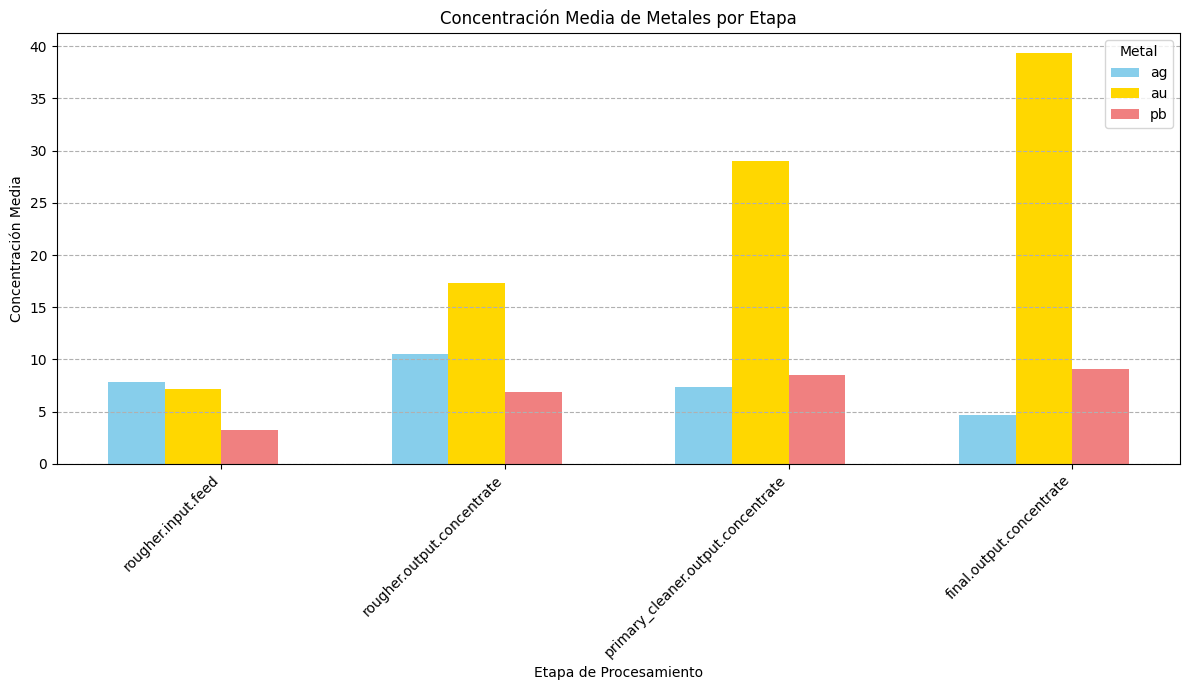

In [269]:
# Definir las etapas y los metales que queremos graficar
etapas = ['rougher.input.feed', 'rougher.output.concentrate', 'primary_cleaner.output.concentrate', 'final.output.concentrate']
metales = ['ag', 'au', 'pb']

# Crear un diccionario para almacenar las concentraciones medias
mean_concentrations = {}
for etapa in etapas:
    mean_concentrations[etapa] = {}
    for metal in metales:
        columna = f"{etapa}_{metal}"
        if columna in df_train_filled.columns:
            mean_concentrations[etapa][metal] = df_train_filled[columna].mean()
        else:
            mean_concentrations[etapa][metal] = np.nan  # Si la columna no existe

# Crear un DataFrame para facilitar la graficación
df_plot = pd.DataFrame(mean_concentrations).T

# Visualización con colores consistentes por metal
fig, ax = plt.subplots(figsize=(12, 7))
bar_width = 0.2
x = np.arange(len(etapas))
colors = {'ag': 'skyblue', 'au': 'gold', 'pb': 'lightcoral'}

for i, metal in enumerate(metales):
    offsets = [(j - len(metales) / 2) * bar_width for j in range(len(metales))]
    y_values = df_plot[metal].values
    ax.bar(x + offsets[i], y_values, bar_width, label=metal, color=colors[metal])

ax.set_xlabel('Etapa de Procesamiento')
ax.set_ylabel('Concentración Media')
ax.set_title('Concentración Media de Metales por Etapa')
ax.set_xticks(x)
ax.set_xticklabels(etapas, rotation=45, ha='right')
ax.legend(title='Metal')
ax.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

Se observa lo siguiente:
- El proceso del oro logra enriquecer la concentración a medida que avanza en las diferentes etapas como se muestra en los gráficos lo que demuestra que el proceso de tratamiento es ideal eliminando otros materiales y refinando de manera correcta.
- La plata no se concentra de la misma manera lo que indica que le proceso se enfoca al oro y se elimina de manera correcta.
- El plomo sigue el mismo comportamiento que el oro lo que sugiere que no se está eliminando tan eficientemente como otros materiales y podría estar concentrándose junto con el oro en el producto final.

## 2.  Compara las distribuciones del tamaño de las partículas de la alimentación en el conjunto de entrenamiento y en el conjunto de prueba.

Las columnas importantes para el comparativo son:
- primary_cleaner.input.feed_size
- rougher.input.feed_size

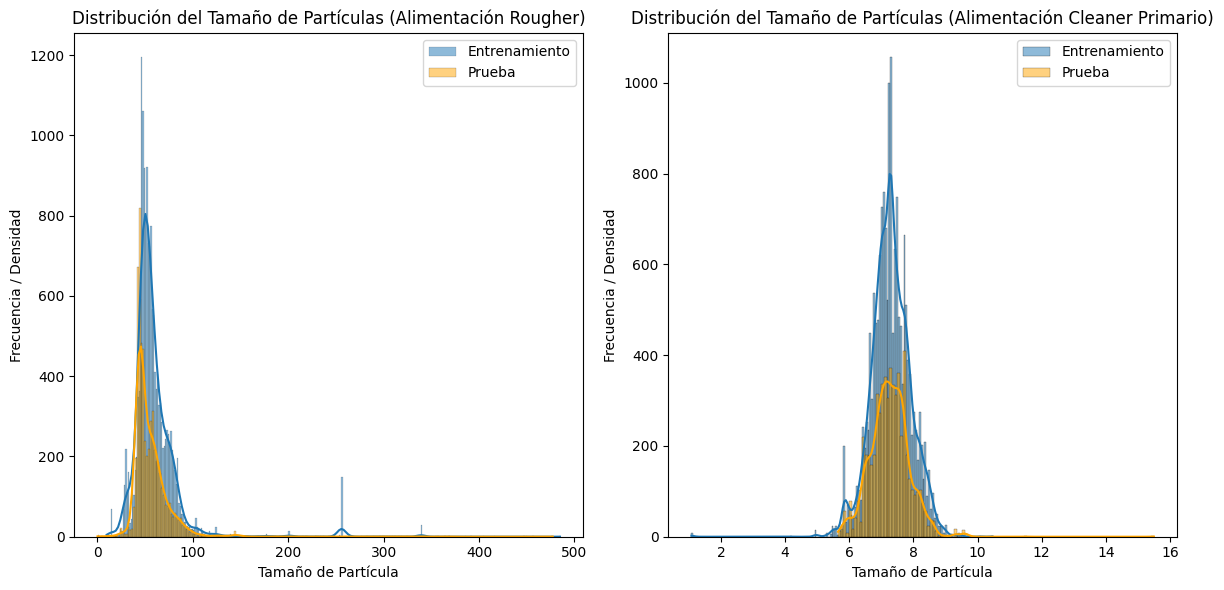

In [270]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_train_filled['rougher.input.feed_size'], kde=True, label='Entrenamiento')
sns.histplot(df_test_filled['rougher.input.feed_size'], kde=True, color='orange', label='Prueba')
plt.title('Distribución del Tamaño de Partículas (Alimentación Rougher)')
plt.xlabel('Tamaño de Partícula')
plt.ylabel('Frecuencia / Densidad')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(df_train_filled['primary_cleaner.input.feed_size'], kde=True, label='Entrenamiento')
sns.histplot(df_test_filled['primary_cleaner.input.feed_size'], kde=True, color='orange', label='Prueba')
plt.title('Distribución del Tamaño de Partículas (Alimentación Cleaner Primario)')
plt.xlabel('Tamaño de Partícula')
plt.ylabel('Frecuencia / Densidad')
plt.legend()

plt.tight_layout()
plt.show()

 Las distribuciones del tamaño de las partículas en las etapas de alimentacion para los conjuntos de entrenamiento y prueba son bastante similares. Esto es una buena señal, ya que nos indica que podremos entrenar al modelo de manera correcta.

## 3. Concentraciones totales en las diferentes etapas

Nos enfocaremos únicamente en la etapa de la materia prima debido a que no tenemos suficiente información en df_test para poder evaluar las otras etapas.

In [271]:
# Agregamos columnas a df_test_filled
columnas_faltantes = ['rougher.output.concentrate_ag','rougher.output.concentrate_pb', 'rougher.output.concentrate_sol','rougher.output.concentrate_au','final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au']
columnas_modelo = ['rougher.output.recovery','final.output.recovery']
for col in columnas_faltantes:
    if col not in df_test_filled.columns:
        df_test_filled[col] = np.nan

df_full_temp = df_full_filled[['date'] + columnas_faltantes + columnas_modelo].copy()
df_test_filled = pd.merge(df_test_filled, df_full_temp, on='date', how='left', suffixes=('', '_full_temp'))

df_test_filled = df_test_filled.drop(columns=columnas_faltantes)

nuevos_nombres = {
    'rougher.output.concentrate_ag_full_temp': 'rougher.output.concentrate_ag',
    'rougher.output.concentrate_pb_full_temp': 'rougher.output.concentrate_pb',
    'rougher.output.concentrate_sol_full_temp': 'rougher.output.concentrate_sol',
    'rougher.output.concentrate_au_full_temp': 'rougher.output.concentrate_au',
    'final.output.concentrate_ag_full_temp': 'final.output.concentrate_ag',
    'final.output.concentrate_pb_full_temp': 'final.output.concentrate_pb',
    'final.output.concentrate_sol_full_temp': 'final.output.concentrate_sol',
    'final.output.concentrate_au_full_temp': 'final.output.concentrate_au',
    'rougher.output.recovery_full_temp': 'rougher.output.recovery',
    'final.output.recovery_full_temp': 'final.output.recovery'
}

df_test_filled.rename(columns=nuevos_nombres, inplace=True)

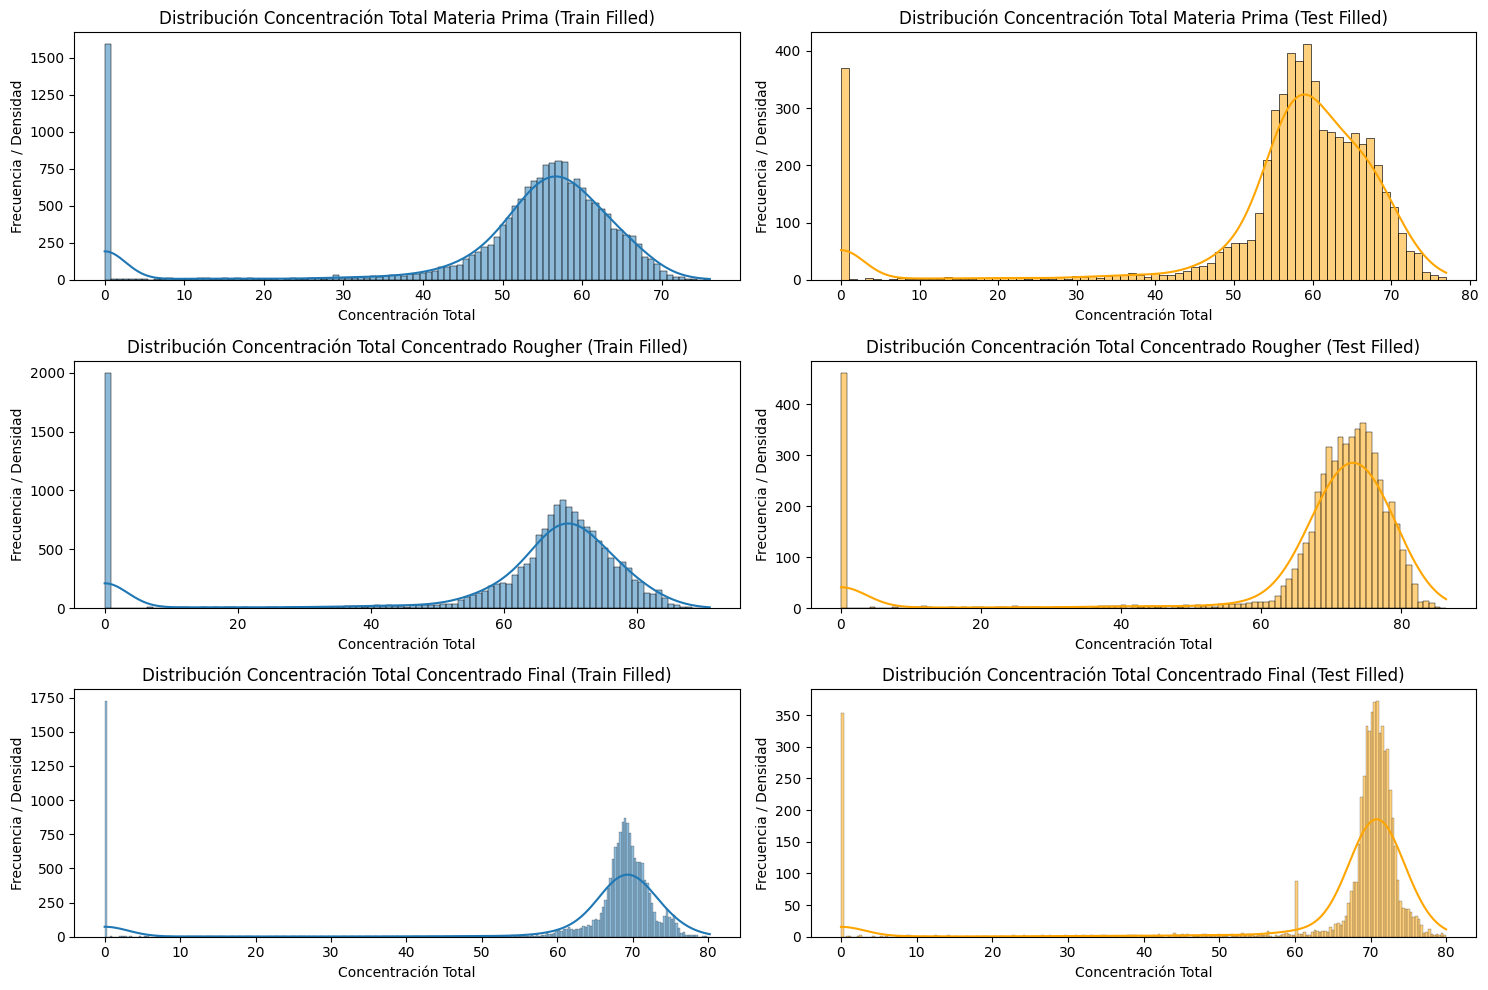

In [272]:
# Etapas
rougher_input_cols = ['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol', 'rougher.input.feed_au']
rougher_output_concentrate_cols = ['rougher.output.concentrate_ag','rougher.output.concentrate_pb','rougher.output.concentrate_sol','rougher.output.concentrate_au']
final_output_concentrate_cols = ['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au']


# Calcular la concentración total de cada etapa en el conjunto de entrenamiento y prueba
df_train_filled['rougher_input_total'] = df_train_filled[rougher_input_cols].sum(axis=1) # Materia prima
df_test_filled['rougher_input_total'] = df_test_filled[rougher_input_cols].sum(axis=1) # Materia prima
df_train_filled['rougher_output_total'] = df_train_filled[rougher_output_concentrate_cols].sum(axis=1) # Concentrado rougher
df_test_filled['rougher_output_total'] = df_test_filled[rougher_output_concentrate_cols].sum(axis=1) # Concentrado rougher
df_train_filled['final_output_total'] = df_train_filled[final_output_concentrate_cols].sum(axis=1) # Concentrado final
df_test_filled['final_output_total'] = df_test_filled[final_output_concentrate_cols].sum(axis=1) # Concentrado final

# Visualización modificada (solo histogramas)
plt.figure(figsize=(15, 10))

plt.subplot(3, 2, 1)
sns.histplot(df_train_filled['rougher_input_total'], kde=True)
plt.title('Distribución Concentración Total Materia Prima (Train Filled)')
plt.xlabel('Concentración Total')
plt.ylabel('Frecuencia / Densidad')

plt.subplot(3, 2, 2)
sns.histplot(df_test_filled['rougher_input_total'], kde=True, color='orange')
plt.title('Distribución Concentración Total Materia Prima (Test Filled)')
plt.xlabel('Concentración Total')
plt.ylabel('Frecuencia / Densidad')

plt.subplot(3, 2, 3)
sns.histplot(df_train_filled['rougher_output_total'], kde=True)
plt.title('Distribución Concentración Total Concentrado Rougher (Train Filled)')
plt.xlabel('Concentración Total')
plt.ylabel('Frecuencia / Densidad')

plt.subplot(3, 2, 4)
sns.histplot(df_test_filled['rougher_output_total'], kde=True, color='orange')
plt.title('Distribución Concentración Total Concentrado Rougher (Test Filled)')
plt.xlabel('Concentración Total')
plt.ylabel('Frecuencia / Densidad')

plt.subplot(3, 2, 5)
sns.histplot(df_train_filled['final_output_total'], kde=True)
plt.title('Distribución Concentración Total Concentrado Final (Train Filled)')
plt.xlabel('Concentración Total')
plt.ylabel('Frecuencia / Densidad')

plt.subplot(3, 2, 6)
sns.histplot(df_test_filled['final_output_total'], kde=True, color='orange')
plt.title('Distribución Concentración Total Concentrado Final (Test Filled)')
plt.xlabel('Concentración Total')
plt.ylabel('Frecuencia / Densidad')

plt.tight_layout()
plt.show()

- Existen anomalias por lo que procedemos a eliminar  valores definiendo un umbral para cada etapa:
    - Materia Prima: 40
    - Rougher: 50
    - Rougher_Final: 60

Materia Prima (rougher input):
  Entrenamiento: Filas eliminadas: 2186
  Prueba: Filas eliminadas: 510


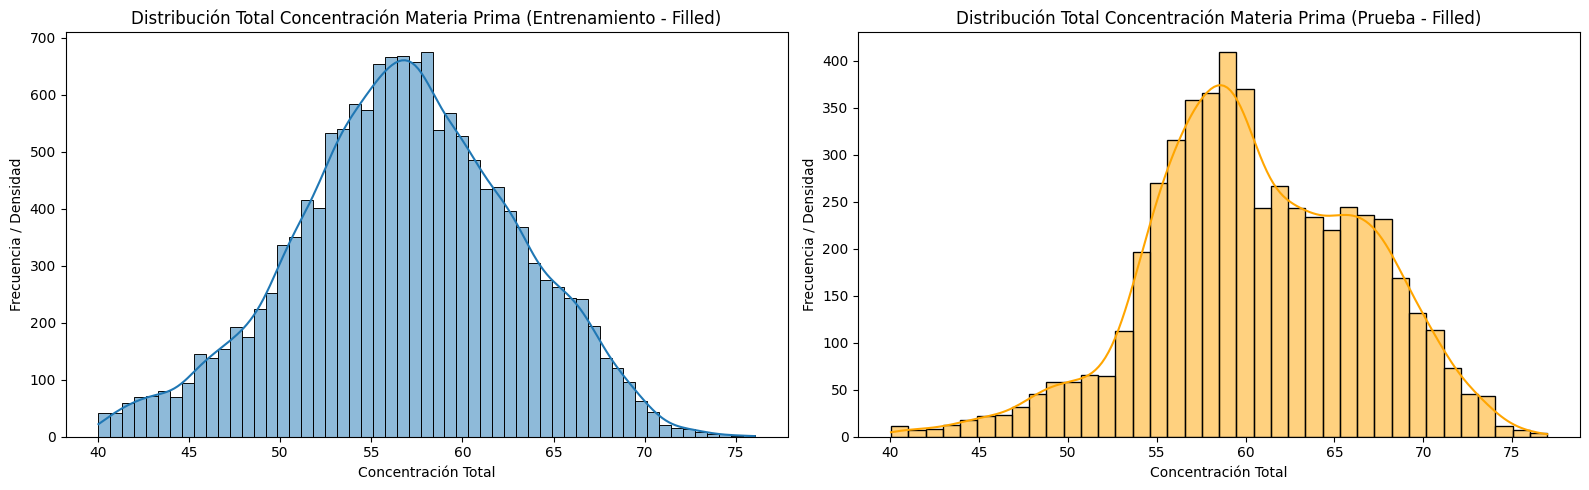


Concentrado Rougher (rougher output):
  Entrenamiento: Filas eliminadas: 842
  Prueba: Filas eliminadas: 161


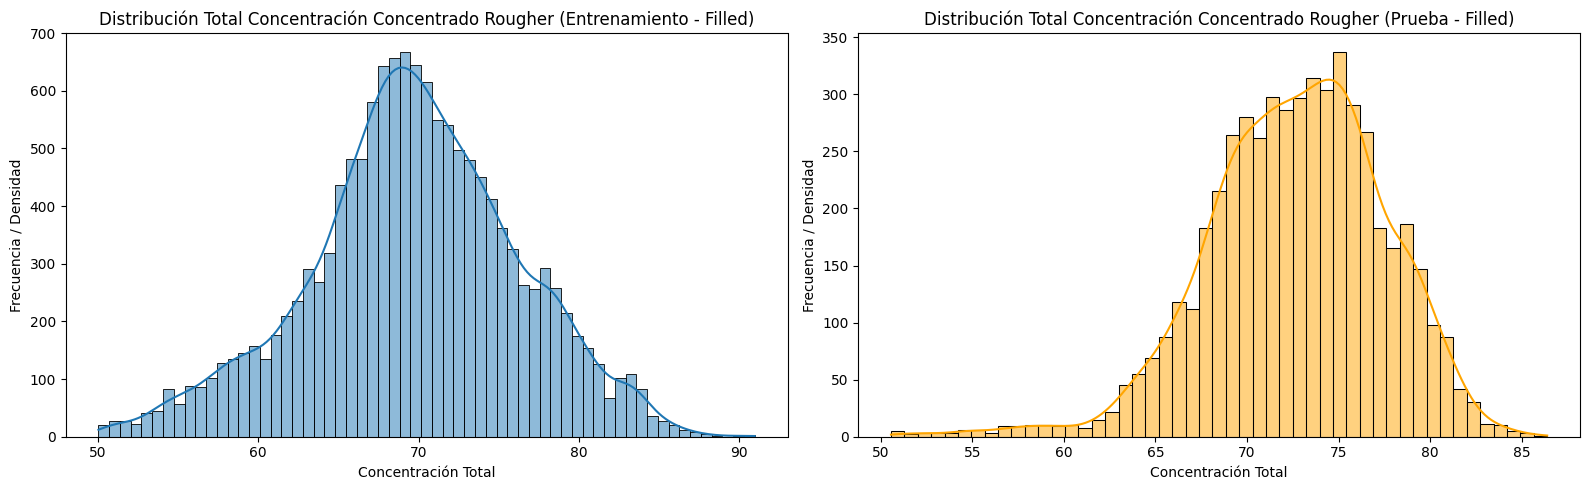


Concentrado Final (final output):
  Entrenamiento: Filas eliminadas: 431
  Prueba: Filas eliminadas: 190


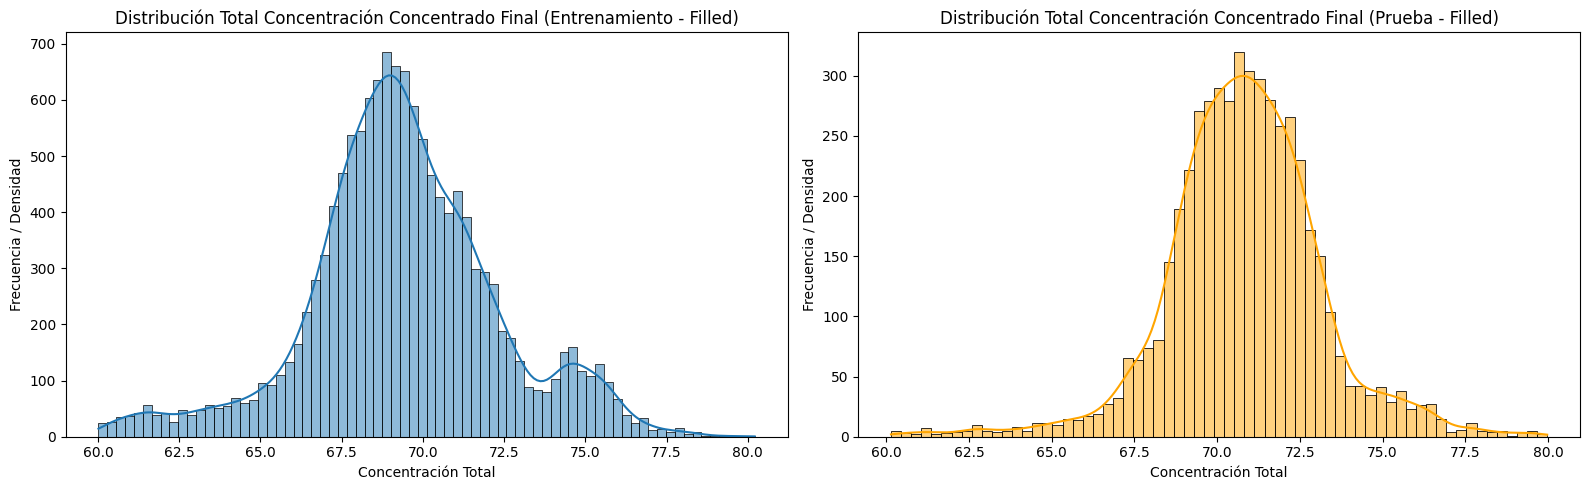

In [273]:
# Umbrales para cada etapa
threshold_rougher_input = 40.0
threshold_rougher_output = 50.0
threshold_final_output = 60.0

# 1. Materia Prima (rougher input)

# Calcular la concentración total en la materia prima (rougher input)
df_train_filled['rougher_input_total'] = df_train_filled[rougher_input_cols].sum(axis=1)
df_test_filled['rougher_input_total'] = df_test_filled[rougher_input_cols].sum(axis=1)

# Identificar y eliminar anomalías
anomalous_indices_train = df_train_filled[df_train_filled['rougher_input_total'] < threshold_rougher_input].index
df_train_filled.drop(anomalous_indices_train, inplace=True)

anomalous_indices_test = df_test_filled[df_test_filled['rougher_input_total'] < threshold_rougher_input].index
df_test_filled.drop(anomalous_indices_test, inplace=True)

print("Materia Prima (rougher input):")
print(f"  Entrenamiento: Filas eliminadas: {len(anomalous_indices_train)}")
print(f"  Prueba: Filas eliminadas: {len(anomalous_indices_test)}")

# Visualización (Materia Prima)
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_train_filled['rougher_input_total'], kde=True)
plt.title('Distribución Total Concentración Materia Prima (Entrenamiento - Filled)')
plt.xlabel('Concentración Total')
plt.ylabel('Frecuencia / Densidad')

plt.subplot(1, 2, 2)
sns.histplot(df_test_filled['rougher_input_total'], kde=True, color='orange')
plt.title('Distribución Total Concentración Materia Prima (Prueba - Filled)')
plt.xlabel('Concentración Total')
plt.ylabel('Frecuencia / Densidad')

plt.tight_layout()
plt.show()

# 2. Concentrado Rougher (rougher output)

# Calcular la concentración total en el concentrado rougher
df_train_filled['rougher_output_total'] = df_train_filled[rougher_output_concentrate_cols].sum(axis=1)
df_test_filled['rougher_output_total'] = df_test_filled[rougher_output_concentrate_cols].sum(axis=1)

# Identificar y eliminar anomalías
anomalous_indices_train = df_train_filled[df_train_filled['rougher_output_total'] < threshold_rougher_output].index
df_train_filled.drop(anomalous_indices_train, inplace=True)

anomalous_indices_test = df_test_filled[df_test_filled['rougher_output_total'] < threshold_rougher_output].index
df_test_filled.drop(anomalous_indices_test, inplace=True)

print("\nConcentrado Rougher (rougher output):")
print(f"  Entrenamiento: Filas eliminadas: {len(anomalous_indices_train)}")
print(f"  Prueba: Filas eliminadas: {len(anomalous_indices_test)}")

# Visualización (Concentrado Rougher)
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_train_filled['rougher_output_total'], kde=True)
plt.title('Distribución Total Concentración Concentrado Rougher (Entrenamiento - Filled)')
plt.xlabel('Concentración Total')
plt.ylabel('Frecuencia / Densidad')

plt.subplot(1, 2, 2)
sns.histplot(df_test_filled['rougher_output_total'], kde=True, color='orange')
plt.title('Distribución Total Concentración Concentrado Rougher (Prueba - Filled)')
plt.xlabel('Concentración Total')
plt.ylabel('Frecuencia / Densidad')

plt.tight_layout()
plt.show()

# 3. Concentrado Final (final output)

# Calcular la concentración total en el concentrado final
df_train_filled['final_output_total'] = df_train_filled[final_output_concentrate_cols].sum(axis=1)
df_test_filled['final_output_total'] = df_test_filled[final_output_concentrate_cols].sum(axis=1)

# Identificar y eliminar anomalías
anomalous_indices_train = df_train_filled[df_train_filled['final_output_total'] < threshold_final_output].index
df_train_filled.drop(anomalous_indices_train, inplace=True)

anomalous_indices_test = df_test_filled[df_test_filled['final_output_total'] < threshold_final_output].index
df_test_filled.drop(anomalous_indices_test, inplace=True)

print("\nConcentrado Final (final output):")
print(f"  Entrenamiento: Filas eliminadas: {len(anomalous_indices_train)}")
print(f"  Prueba: Filas eliminadas: {len(anomalous_indices_test)}")

# Visualización (Concentrado Final)
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_train_filled['final_output_total'], kde=True)
plt.title('Distribución Total Concentración Concentrado Final (Entrenamiento - Filled)')
plt.xlabel('Concentración Total')
plt.ylabel('Frecuencia / Densidad')

plt.subplot(1, 2, 2)
sns.histplot(df_test_filled['final_output_total'], kde=True, color='orange')
plt.title('Distribución Total Concentración Concentrado Final (Prueba - Filled)')
plt.xlabel('Concentración Total')
plt.ylabel('Frecuencia / Densidad')

plt.tight_layout()
plt.show()

- Se observan anomalias en cada etapa por lo que es prudente eliminarlas para el buen entrenamiento del modelo y tener predicciones mas exactas.
- Se definieron diferentes umbrales para cada etapa para tener mayor presicion.

# 3. Construye el modelo

## 1. Escribe una función para calcular el valor final de sMAPE.

In [274]:
def smape(y_true, y_pred):
    """
    Calcula el Symmetric Mean Absolute Percentage Error (SMAPE).
    """
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

def final_smape(rougher_true, rougher_pred, final_true, final_pred):
    """
    Calcula el SMAPE final ponderado (25% rougher, 75% final).
    """
    smape_rougher = smape(rougher_true, rougher_pred)
    smape_final = smape(final_true, final_pred)
    return 0.25 * smape_rougher + 0.75 * smape_final

In [275]:
# Alineamos caracteristicas y objetivos
train_cols = set(df_train_filled.columns)
test_cols = set(df_test_filled.columns)

# Columnas comunes a ambos DataFrames
common_cols = list(train_cols.intersection(test_cols))
common_cols.sort()  # Importante: Ordenar las columnas

df_train_cleaned= df_train_filled[common_cols]
df_test_cleaned = df_test_filled[common_cols]

## 2. Entrena diferentes modelos. Evalúalos aplicando la validación cruzada

In [276]:
# Preparamos datos del modelo:
features_train = df_train_cleaned.drop(columns=['date', 'final.output.recovery', 'rougher.output.recovery'], errors='ignore')
target_rougher_train = df_train_cleaned['rougher.output.recovery']
target_final_train = df_train_cleaned['final.output.recovery']

features_test = df_test_cleaned.drop(columns=['date', 'final.output.recovery', 'rougher.output.recovery'], errors='ignore')
target_rougher_test = df_test_cleaned['rougher.output.recovery']
target_final_test = df_test_cleaned['final.output.recovery']

In [277]:
models = {
    'RandomForest': RandomForestRegressor(random_state=12345),
    'DecisionTree': DecisionTreeRegressor(random_state=12345),  # Cambio aquí
    'LinearRegression': LinearRegression()
}

# 3. Configurar la validación cruzada y el scoring
cv = KFold(n_splits=3, shuffle=True, random_state=12345)
smape_scorer = make_scorer(smape, greater_is_better=False)

# 4. Entrenar y evaluar modelos con validación cruzada
results = {}
for name, model in models.items():
    pipeline_rougher = Pipeline([('scaler', StandardScaler()), ('model', model)])
    pipeline_final = Pipeline([('scaler', StandardScaler()), ('model', model)])

    cv_scores_rougher = cross_val_score(pipeline_rougher, features_train, target_rougher_train, cv=cv, scoring=smape_scorer)
    cv_scores_final = cross_val_score(pipeline_final, features_train, target_final_train, cv=cv, scoring=smape_scorer)

    # Calcular el SMAPE final ponderado para cada fold y promediar
    final_smape_scores = []
    for i in range(cv.get_n_splits()):
        final_smape_scores.append(0.25 * cv_scores_rougher[i] + 0.75 * cv_scores_final[i])
    results[name] = np.mean(final_smape_scores)

# 5. Imprimir resultados de la validación cruzada
print("Resultados de la validación cruzada:")
for name, score in results.items():
    print(f"- {name}: SMAPE final promedio = {score:.4f}")  # Imprimir el valor negativo

# 6. Seleccionar el mejor modelo
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f"\nMejor modelo: {best_model_name}")

# 7. Entrenar el mejor modelo en todo el conjunto de entrenamiento
pipeline_best_rougher = Pipeline([('scaler', StandardScaler()), ('model', best_model)])
pipeline_best_final = Pipeline([('scaler', StandardScaler()), ('model', best_model)])

pipeline_best_rougher.fit(features_train, target_rougher_train)
pipeline_best_final.fit(features_train, target_final_train)

# 8. Hacer predicciones en el conjunto de prueba
rougher_predictions_test = pipeline_best_rougher.predict(features_test)
final_predictions_test = pipeline_best_final.predict(features_test)

# 9. Calcular el SMAPE final en el conjunto de prueba
final_smape_test = final_smape(
    target_rougher_test, rougher_predictions_test,
    target_final_test, final_predictions_test
)

# 10. Facilitar los resultados
print(f"\nSMAPE final en el conjunto de prueba para el mejor modelo ({best_model_name}): {final_smape_test:.2f}%")



Resultados de la validación cruzada:
- RandomForest: SMAPE final promedio = -4.3947
- DecisionTree: SMAPE final promedio = -6.3132
- LinearRegression: SMAPE final promedio = -6.6659

Mejor modelo: RandomForest

SMAPE final en el conjunto de prueba para el mejor modelo (RandomForest): 11.85%


# CONCLUSIONES

- Observamos que el mejor modelo para predicción es Randomforest con una validacion cruzada de 4.3 aplicado el cual se aplica al conjunto de prueba y da un SMAPE final de 11% lo cual se considera un valor bueno.
- Se configuraron 3 modelos con pipeline para arrojar los mejores resultados
- El modelo a elegir es un Randomforest para nuestro modelo de oro extraido